<a href="https://colab.research.google.com/github/sreeshma15/ForecastingWaterConsumption/blob/main/PROJECT(updated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print(" ML ENVIRONMENT SETUP COMPLETED")

 ML ENVIRONMENT SETUP COMPLETED


In [ ]:
print("\n=== PHASE 1: DATA EXPLORATION & UNDERSTANDING ===")
print("=" * 60)

# Load the organized dataset
df = pd.read_csv('/content/drive/MyDrive/WaterConsumptionDataset(Finalized).csv')

print("1.1 DATASET STRUCTURE EXAMINATION")
print("-" * 40)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nData Types:")
print(df.dtypes)

print("\n1.2 COMPREHENSIVE DATA PROFILING")
print("-" * 40)

print("Missing Values Analysis:")
print(df.isnull().sum())

print(f"\nBasic Statistics:")
print(df.describe())

print(f"\nCategorical Variables Summary:")
categorical_cols = ['Country', 'Water Scarcity Level']
for col in categorical_cols:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts())
    else:
        print(f"\nColumn '{col}' not found in the DataFrame.")


print("\n1.3 TEMPORAL AND GEOGRAPHICAL ANALYSIS")
print("-" * 40)

print(f"Year Range: {df['Year'].min()} to {df['Year'].max()}")
print(f"Number of Countries: {df['Country'].nunique()}")
print(f"Countries: {df['Country'].unique()}")

# Check data distribution by country and year
country_years = df.groupby('Country')['Year'].agg(['min', 'max', 'count'])
print(f"\nCountry-wise Data Distribution:")
print(country_years)


=== PHASE 1: DATA EXPLORATION & UNDERSTANDING ===
1.1 DATASET STRUCTURE EXAMINATION
----------------------------------------
Dataset Shape: (700, 15)
Columns: ['Year', 'Country code', 'Country', 'Population', 'Total Water Consumption(Billion Cubic Meters)', 'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)', 'Industrial Water Use (%)', 'Household Water Use (%)', 'Rainfall Impact (Annual Precipitation in mm)', 'Groundwater Depletion Rate (%)', 'Water Scarcity Level', 'Number of dams', 'Reservoir_Capacity_TMC', 'Number_of_Industries']

First 5 rows:
   Year  Country code Country    Population  \
0  1990           356   India  40,51,23,000   
1  1990           156   China    1130000000   
2  1990           840     USA     249000000   
3  1990            76  Brazil     149000000   
4  1990           643  Russia     148000000   

   Total Water Consumption(Billion Cubic Meters)  \
0                                          350.0   
1                                      

In [ ]:
# print("\n=== PHASE 2: DATA CLEANING ===")
# print("=" * 60)

# # 2.1 Handling Missing Values
# print("2.1 Handling Missing Values")
# print("-" * 40)

# # Fill missing 'Country' values with 'India'
# df['Country'].fillna('India', inplace=True)
# print("Missing values in 'Country' column filled with 'India'.")

# print("\nMissing Values Analysis after handling:")
# print(df.isnull().sum())

# # 2.2 Handling Data Types and Formats
# print("\n2.2 Handling Data Types and Formats")
# print("-" * 40)

# # Convert 'Population' to numeric by removing commas
# df['Population'] = df['Population'].str.replace(',', '').astype(float)
# print(" 'Population' column converted to numeric.")

# print("\nData Types after handling:")
# print(df.dtypes)

# print("\nData Cleaning complete.")




print("\n=== PHASE 2: DATA CLEANING FOR GLOBAL DATASET ===")
print("=" * 60)

# 2.1 Comprehensive Missing Values Analysis
print("2.1 Global Missing Values Analysis")
print("-" * 40)

# Initial missing values assessment
print("Initial Missing Values by Column:")
missing_summary = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_analysis = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percentage': missing_percentage
})
print(missing_analysis[missing_analysis['Missing_Count'] > 0])

# 2.2 Handle Missing Values Strategically
print("\n2.2 Strategic Missing Value Handling")
print("-" * 40)

# Critical columns - cannot have missing values
critical_columns = ['Country', 'Year', 'Country code']
for col in critical_columns:
    if col in df.columns and df[col].isnull().any():
        print(f"Critical column '{col}' has {df[col].isnull().sum()} missing values - DROPPING ROWS")
        df = df.dropna(subset=[col])

# Country-specific handling - DO NOT default to 'India'
if 'Country' in df.columns:
    unique_countries = df['Country'].nunique()
    print(f"Dataset contains {unique_countries} unique countries")

    # Show countries with missing data (if any)
    if df['Country'].isnull().any():
        print(" Missing country values found - these rows will be dropped")
        df = df.dropna(subset=['Country'])

# Numerical columns - impute with median by country group
numerical_columns = [
    'Total Water Consumption(Billion Cubic Meters)',
    'Per Capita Water Use (Liters per Day)',
    'Agricultural Water Use (%)',
    'Industrial Water Use (%)',
    'Household Water Use (%)',
    'Rainfall Impact (Annual Precipitation in mm)',
    'Groundwater Depletion Rate (%)',
    'Number of dams',
    'Reservoir_Capacity_TMC',
    'Number_of_Industries'
]

print("\nHandling missing numerical values by country groups...")
for col in numerical_columns:
    if col in df.columns and df[col].isnull().any():
        missing_before = df[col].isnull().sum()
        # Impute with country-specific median
        df[col] = df.groupby('Country')[col].transform(
            lambda x: x.fillna(x.median())
        )
        # If still missing (e.g., entire country missing), use global median
        df[col] = df[col].fillna(df[col].median())
        missing_after = df[col].isnull().sum()
        print(f"{col}: {missing_before} → {missing_after} missing values")

# # 2.3 Data Type Conversion and Format Standardization
# print("\n2.3 Data Type Conversion and Format Standardization")
# print("-" * 40)

# # Handle Population column with various formats
# if 'Population' in df.columns:
#     print("Processing 'Population' column...")

#     # Convert to string first to handle various formats
#     df['Population'] = df['Population'].astype(str)

#     # Remove commas, spaces, and other non-numeric characters (except decimal point)
#     df['Population'] = df['Population'].str.replace(',', '').str.replace(' ', '')

#     # Handle scientific notation and other formats
#     df['Population'] = pd.to_numeric(df['Population'], errors='coerce')

#     # Check for any remaining conversion issues
#     conversion_issues = df['Population'].isnull().sum()
#     if conversion_issues > 0:
#         print(f"{conversion_issues} population values could not be converted - using median imputation")
#         df['Population'] = df['Population'].fillna(df['Population'].median())

#     print(f"Population converted to numeric: {df['Population'].dtype}")

# # Convert other numerical columns
# numerical_conversions = [
#     'Total Water Consumption(Billion Cubic Meters)',
#     'Per Capita Water Use (Liters per Day)',
#     'Agricultural Water Use (%)',
#     'Industrial Water Use (%)',
#     'Household Water Use (%)',
#     'Rainfall Impact (Annual Precipitation in mm)',
#     'Groundwater Depletion Rate (%)',
#     'Number of dams',
#     'Reservoir_Capacity_TMC',
#     'Number_of_Industries'
# ]

# for col in numerical_conversions:
#     if col in df.columns:
#         df[col] = pd.to_numeric(df[col], errors='coerce')
#         # Fill any remaining NaN with median
#         df[col] = df[col].fillna(df[col].median())
#         print(f"{col}: converted to numeric")

# # Ensure categorical columns are properly typed
# categorical_columns = ['Country', 'Water Scarcity Level']
# for col in categorical_columns:
#     if col in df.columns:
#         df[col] = df[col].astype('category')
#         print(f"{col}: converted to categorical with {df[col].nunique()} categories")

# # 2.4 Data Validation and Quality Checks
# print("\n2.4 Data Validation and Quality Checks")
# print("-" * 40)

# # Check for duplicate rows
# duplicates = df.duplicated().sum()
# print(f"Duplicate rows: {duplicates}")
# if duplicates > 0:
#     df = df.drop_duplicates()
#     print(f"Removed {duplicates} duplicate rows")

# # Validate percentage columns sum to ~100% (with tolerance)
# percentage_columns = ['Agricultural Water Use (%)', 'Industrial Water Use (%)', 'Household Water Use (%)']
# if all(col in df.columns for col in percentage_columns):
#     percentage_sum = df[percentage_columns].sum(axis=1)
#     invalid_percentages = (percentage_sum < 95) | (percentage_sum > 105)
#     print(f"Rows with water use percentages outside 95-105% range: {invalid_percentages.sum()}")

#     if invalid_percentages.any():
#         print("Some water use percentages don't sum to ~100% - this may require investigation")

# # Check for unrealistic values
# def validate_ranges(df):
#     """Validate that numerical values are within reasonable ranges"""
#     validation_checks = {
#         'Population': (0, 2e9),  # 0 to 2 billion
#         'Total Water Consumption(Billion Cubic Meters)': (0, 5000),  # 0 to 5000 billion m³
#         'Per Capita Water Use (Liters per Day)': (0, 5000),  # 0 to 5000 liters/day
#         'Agricultural Water Use (%)': (0, 100),
#         'Industrial Water Use (%)': (0, 100),
#         'Household Water Use (%)': (0, 100),
#         'Groundwater Depletion Rate (%)': (0, 100)
#     }

#     print("\nRange Validation Results:")
#     for col, (min_val, max_val) in validation_checks.items():
#         if col in df.columns:
#             outliers = ((df[col] < min_val) | (df[col] > max_val)).sum()
#             if outliers > 0:
#                 print(f" {col}: {outliers} values outside expected range [{min_val}, {max_val}]")
#             else:
#                 print(f"{col}: All values within expected range")

# validate_ranges(df)

# # 2.5 Handle Inconsistent Categorical Values
# print("\n2.5 Categorical Data Standardization")
# print("-" * 40)

# # Standardize Water Scarcity Level categories
# if 'Water Scarcity Level' in df.columns:
#     print("Standardizing 'Water Scarcity Level' categories...")

#     # Map variations to standard categories
#     scarcity_mapping = {
#         'low': 'Low', 'Low': 'Low', 'LOW': 'Low',
#         'moderate': 'Moderate', 'Moderate': 'Moderate', 'MODERATE': 'Moderate',
#         'high': 'High', 'High': 'High', 'HIGH': 'High',
#         'severe': 'Severe', 'Severe': 'Severe', 'SEVERE': 'Severe'
#     }

#     # Add 'Unknown' to categories BEFORE mapping
#     if 'Unknown' not in df['Water Scarcity Level'].cat.categories:
#          df['Water Scarcity Level'] = df['Water Scarcity Level'].cat.add_categories('Unknown')


#     # Apply mapping and handle unknown values
#     df['Water Scarcity Level'] = df['Water Scarcity Level'].map(scarcity_mapping).fillna('Unknown')

#     category_counts = df['Water Scarcity Level'].value_counts()
#     print("Water Scarcity Level distribution:")
#     for level, count in category_counts.items():
#         print(f"  {level}: {count} records")

# # Country name standardization (example for common issues)
# if 'Country' in df.columns:
#     country_mapping = {
#         'USA': 'United States',
#         'US': 'United States',
#         'U.S.A.': 'United States',
#         'UK': 'United Kingdom',
#         'U.K.': 'United Kingdom',
#         'Russia': 'Russian Federation'
#     }
#     df['Country'] = df['Country'].replace(country_mapping)
#     print(f"✅ Country names standardized: {df['Country'].nunique()} unique countries")

# # 2.6 Final Data Quality Report
# print("\n2.6 Final Data Quality Report")
# print("-" * 40)

# print("DATASET OVERVIEW:")
# print(f"   Total Rows: {len(df):,}")
# print(f"   Total Columns: {len(df.columns):,}")
# print(f"   Date Range: {df['Year'].min()} - {df['Year'].max()}")
# print(f"   Countries: {df['Country'].nunique():,}")
# print(f"   Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# print("\nDATA QUALITY METRICS:")
# print(f"   Missing Values: {df.isnull().sum().sum():,}")
# print(f"   Duplicate Rows: {df.duplicated().sum():,}")
# print(f"   Data Types:")
# for dtype in df.dtypes.value_counts().items():
#     print(f"     {dtype[0]}: {dtype[1]} columns")

# print("\nCOUNTRY COVERAGE:")
# top_countries = df['Country'].value_counts().head(10)
# print("   Top 10 countries by data points:")
# for country, count in top_countries.items():
#     print(f"     {country}: {count} records")

# print("\nGLOBAL DATA CLEANING COMPLETE")
# print("=" * 60)


=== PHASE 2: DATA CLEANING FOR GLOBAL DATASET ===
2.1 Global Missing Values Analysis
----------------------------------------
Initial Missing Values by Column:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

2.2 Strategic Missing Value Handling
----------------------------------------
Dataset contains 20 unique countries

Handling missing numerical values by country groups...


Creating basic dashboard...


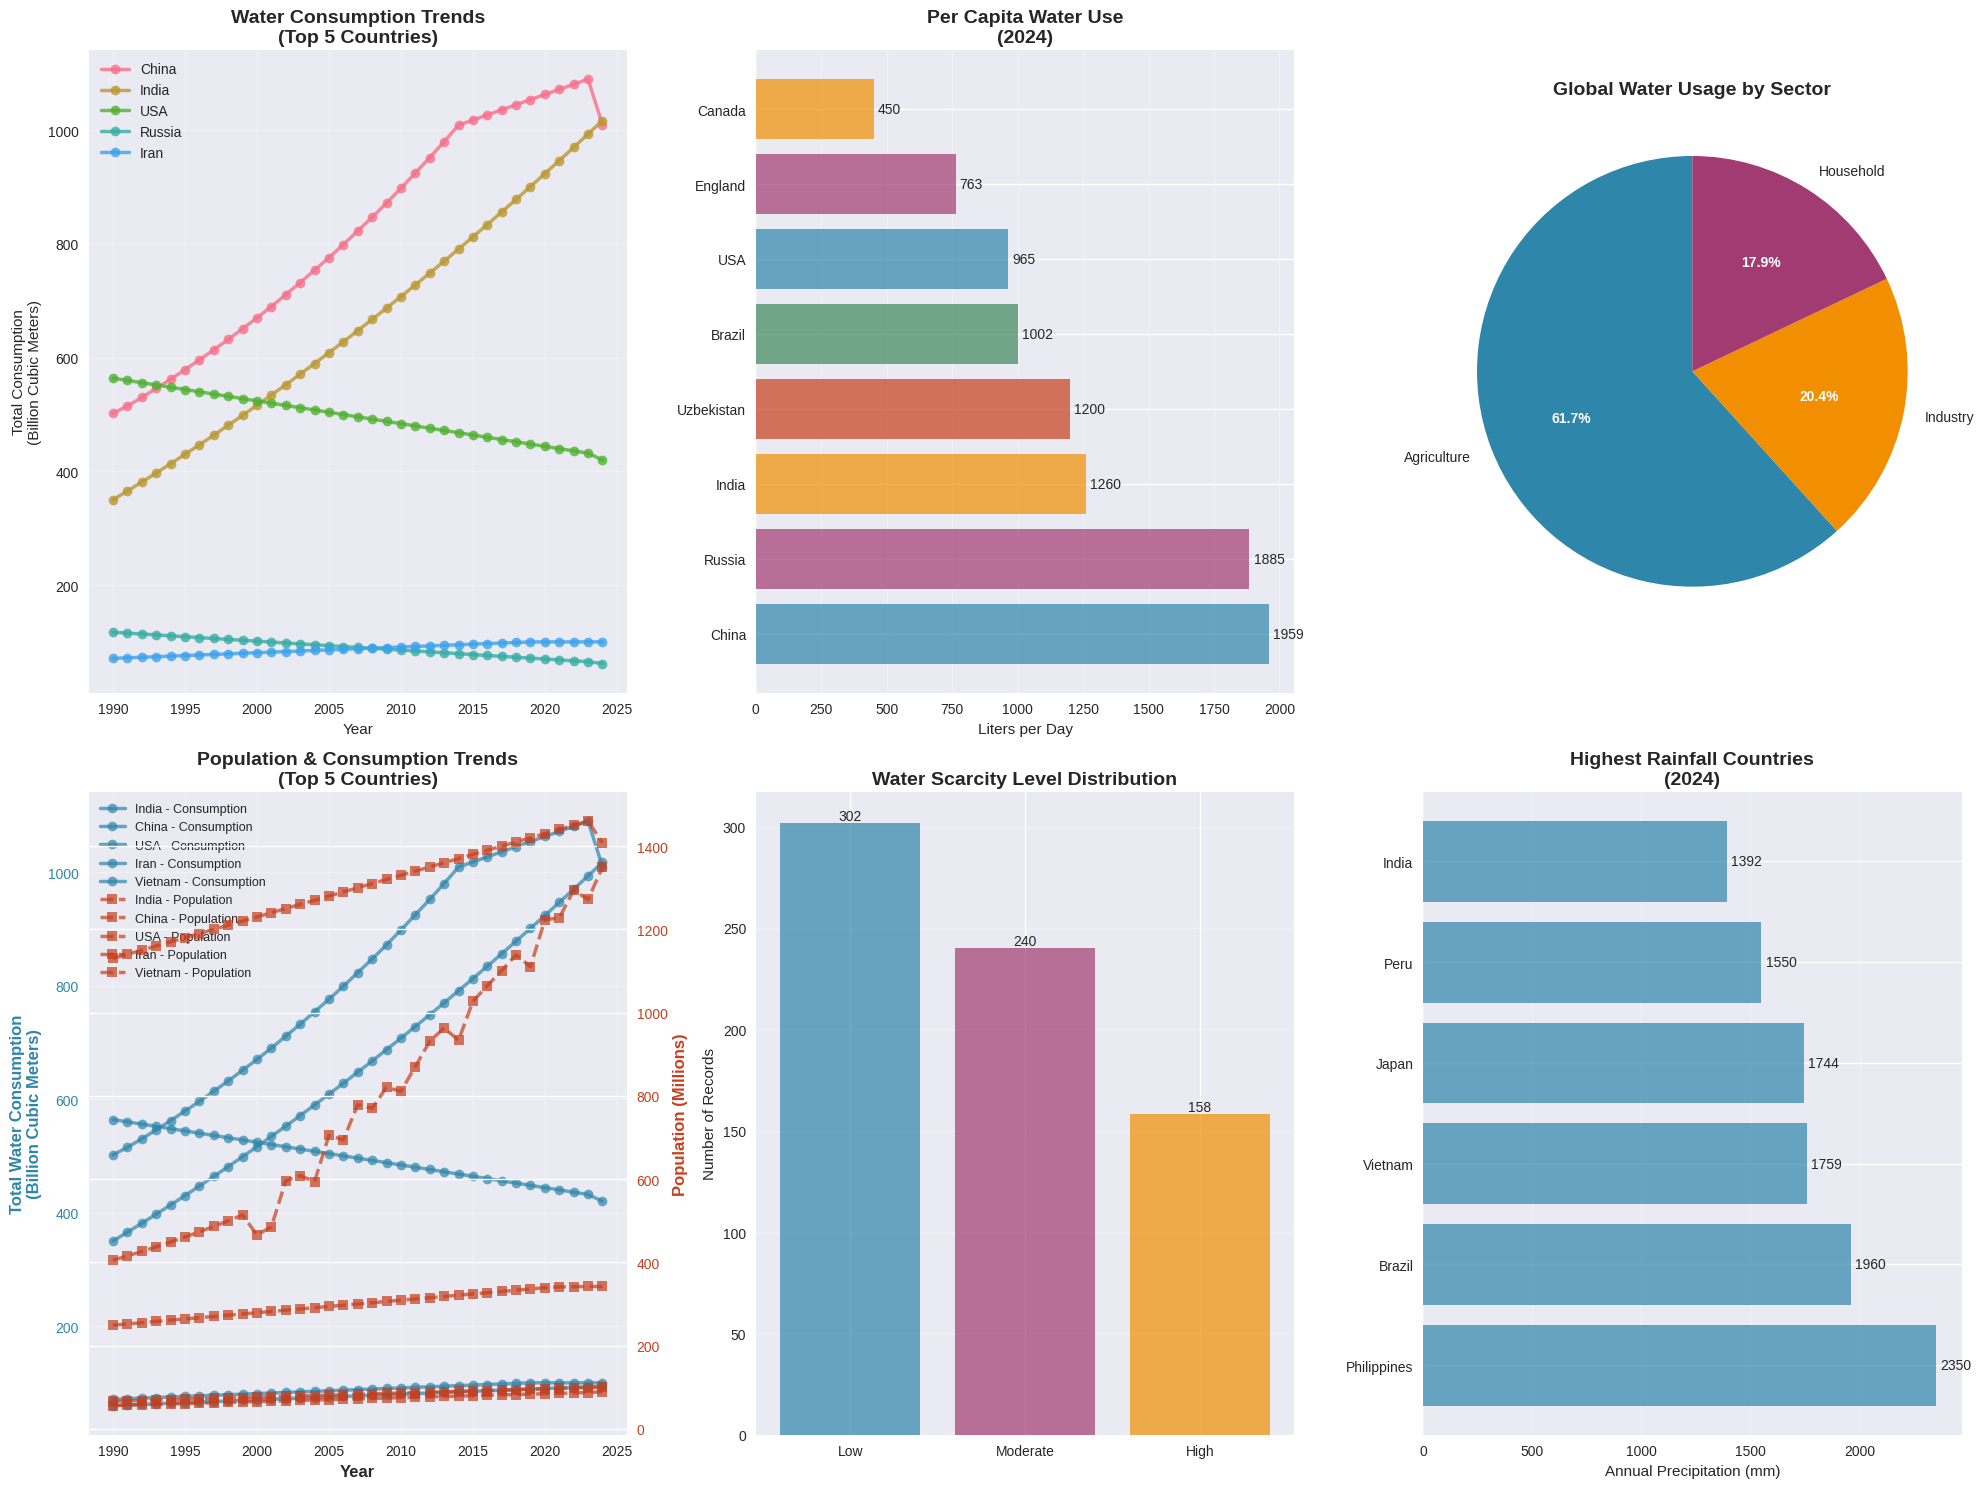

Creating correlation analysis...


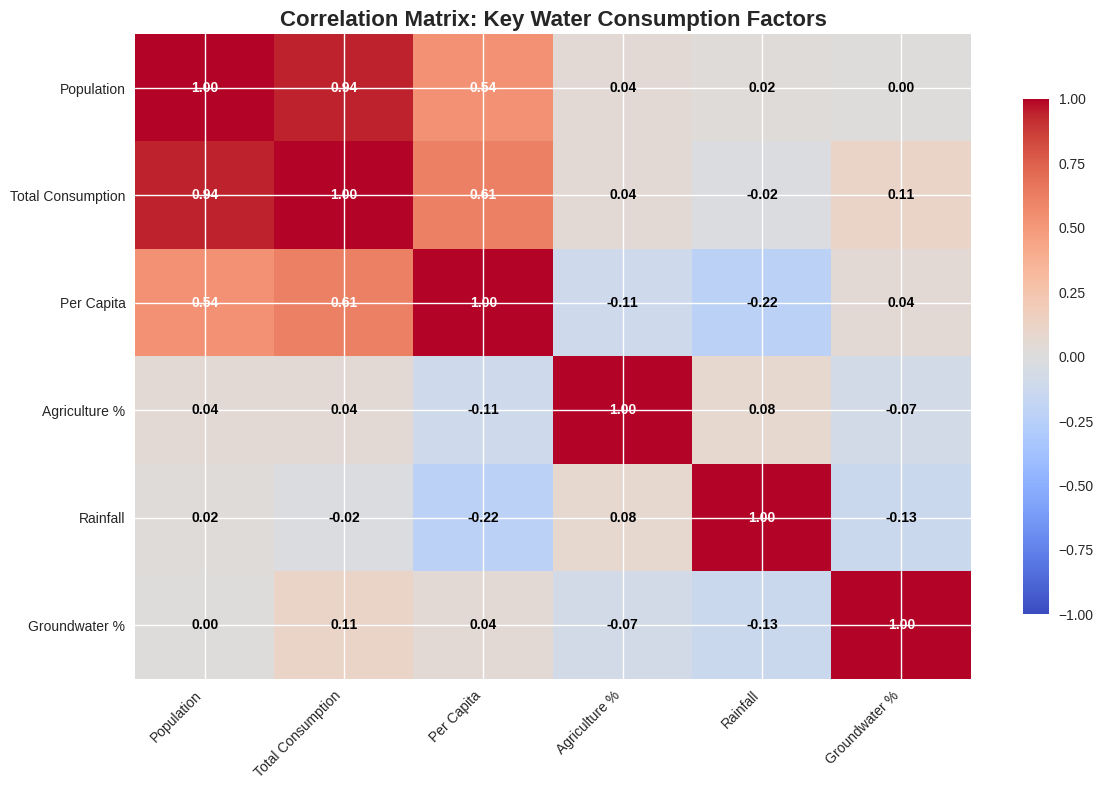

Creating country comparison...


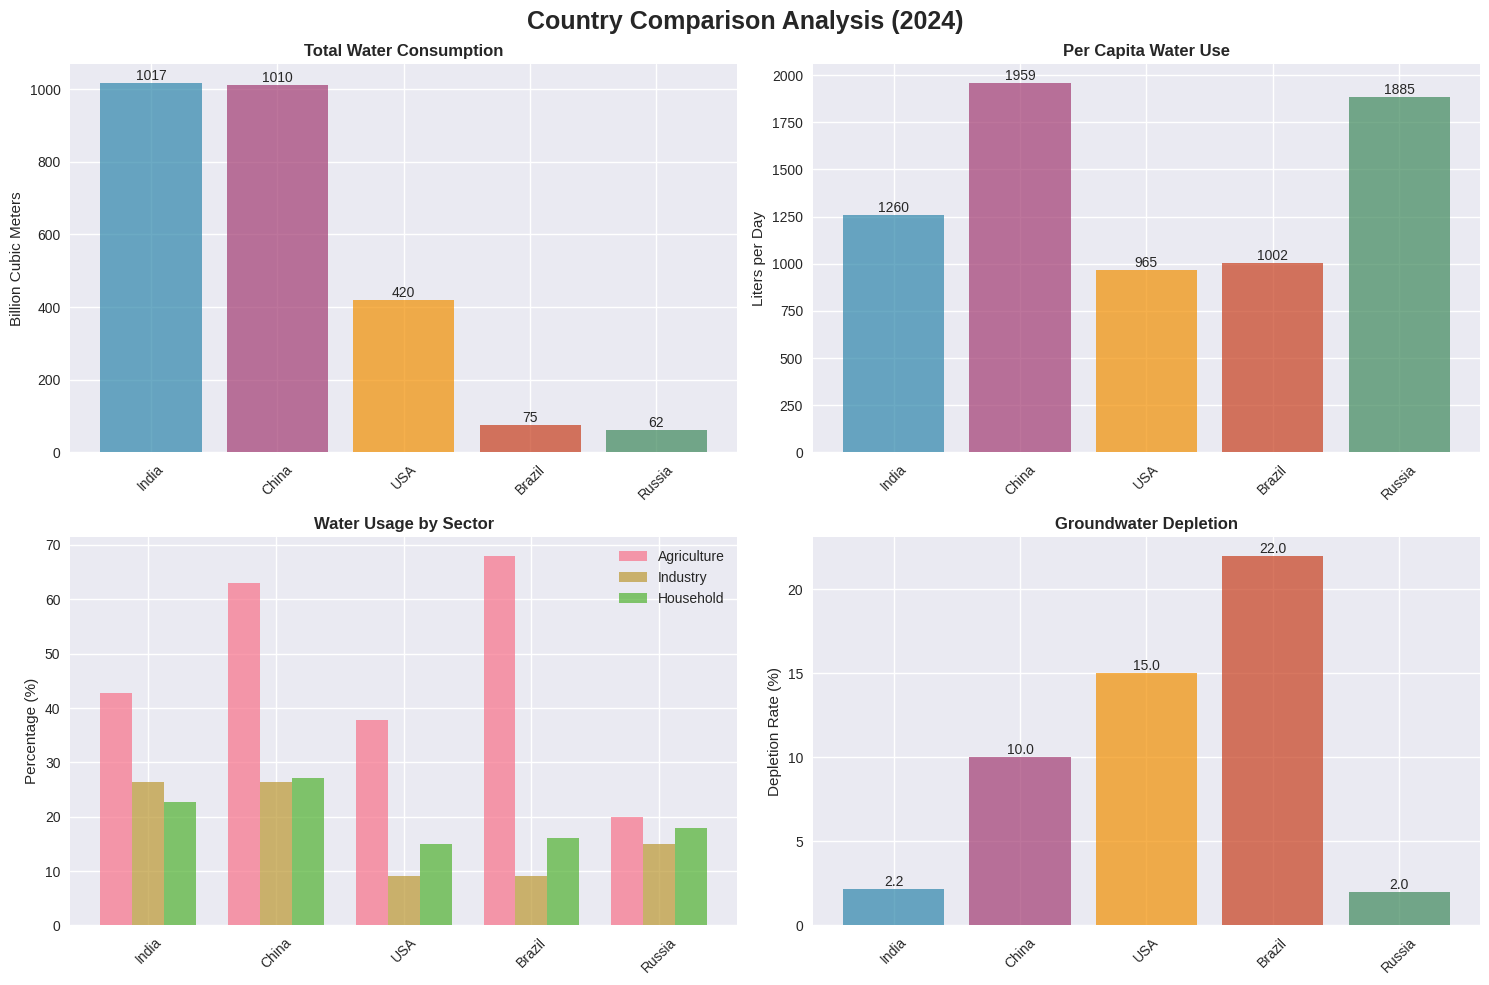

Basic analysis completed successfully!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visuals
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class BasicWaterConsumptionVisualizer:
    def __init__(self, df):
        """
        Initialize the visualizer with global water consumption data
        """
        self.df = df.copy()
        self._preprocess_data()

        # Set up color scheme
        self.colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3E885B']

    def _preprocess_data(self):
        """Preprocess the dataset"""
        # Clean population column (remove commas and convert to numeric)
        self.df['Population'] = self.df['Population'].astype(str).str.replace(',', '').astype(float)

        # Convert percentage columns to proper format
        percentage_cols = ['Agricultural Water Use (%)', 'Industrial Water Use (%)',
                          'Household Water Use (%)', 'Groundwater Depletion Rate (%)']
        for col in percentage_cols:
            self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

        # Convert year to datetime for better plotting
        self.df['Year'] = pd.to_datetime(self.df['Year'], format='%Y')

    def create_basic_dashboard(self, figsize=(20, 15)):
        """
        Create a basic dashboard with essential plots
        """
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        # fig.suptitle('Basic Water Consumption Analysis Dashboard', fontsize=20, fontweight='bold', y=0.95)

        # Plot 1: Total Consumption Trends (Top 5 Countries)
        self._plot_basic_consumption_trend(axes[0, 0])

        # Plot 2: Per Capita Water Use (Latest Year)
        self._plot_basic_per_capita(axes[0, 1])

        # Plot 3: Sector Usage Distribution
        self._plot_basic_sector_usage(axes[0, 2])

        # Plot 4: Population vs Consumption
        self._plot_population_consumption_trend(axes[1, 0])

        # Plot 5: Water Scarcity Distribution
        self._plot_basic_scarcity(axes[1, 1])

        # Plot 6: Rainfall Analysis
        self._plot_basic_rainfall(axes[1, 2])

        plt.tight_layout()
        return fig

    def _plot_basic_consumption_trend(self, ax):
        """Plot basic consumption trends for top 5 countries"""
        top_countries = self.df.groupby('Country')['Total Water Consumption(Billion Cubic Meters)'].max().nlargest(5).index
        filtered_df = self.df[self.df['Country'].isin(top_countries)]

        for country in top_countries:
            country_data = filtered_df[filtered_df['Country'] == country]
            ax.plot(country_data['Year'].dt.year, country_data['Total Water Consumption(Billion Cubic Meters)'],
                   label=country, linewidth=2.5, alpha=0.8, marker='o')

        ax.set_title('Water Consumption Trends\n(Top 5 Countries)', fontsize=14, fontweight='bold')
        ax.set_xlabel('Year')
        ax.set_ylabel('Total Consumption\n(Billion Cubic Meters)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def _plot_basic_per_capita(self, ax):
        """Plot per capita water use for latest year"""
        latest_year = self.df['Year'].max()
        latest_data = self.df[self.df['Year'] == latest_year]

        # Get top 8 countries by per capita usage
        top_countries = latest_data.nlargest(8, 'Per Capita Water Use (Liters per Day)')

        bars = ax.barh(top_countries['Country'], top_countries['Per Capita Water Use (Liters per Day)'],
                      color=self.colors, alpha=0.7)

        ax.set_title(f'Per Capita Water Use\n({latest_year.year})', fontsize=14, fontweight='bold')
        ax.set_xlabel('Liters per Day')
        ax.bar_label(bars, fmt='%.0f', padding=3)
        ax.grid(True, alpha=0.3, axis='x')

    def _plot_basic_sector_usage(self, ax):
        """Plot water usage distribution by sector"""
        sector_cols = ['Agricultural Water Use (%)', 'Industrial Water Use (%)', 'Household Water Use (%)']
        avg_usage = self.df[sector_cols].mean()

        colors = ['#2E86AB', '#F18F01', '#A23B72']
        wedges, texts, autotexts = ax.pie(avg_usage, labels=['Agriculture', 'Industry', 'Household'],
                                         autopct='%1.1f%%', colors=colors, startangle=90)

        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')

        ax.set_title('Global Water Usage by Sector', fontsize=14, fontweight='bold')

    def _plot_population_consumption_trend(self, ax):
        """Plot population and consumption trends over time for top countries"""
        # Get top 5 countries by latest consumption
        latest_year = self.df['Year'].max()
        top_countries = self.df[self.df['Year'] == latest_year].nlargest(5, 'Total Water Consumption(Billion Cubic Meters)')['Country'].values

        # Create a second y-axis for population
        ax2 = ax.twinx()

        # Define colors for the two y-axes
        consumption_color = '#2E86AB'
        population_color = '#C73E1D'

        for country in top_countries:
            country_data = self.df[self.df['Country'] == country].sort_values('Year')

            # Plot consumption on primary y-axis
            ax.plot(country_data['Year'].dt.year,
                   country_data['Total Water Consumption(Billion Cubic Meters)'],
                   label=f'{country} - Consumption', color=consumption_color,
                   linewidth=2.5, alpha=0.7, marker='o')

            # Plot population on secondary y-axis
            ax2.plot(country_data['Year'].dt.year,
                    country_data['Population']/1e6,  # Convert to millions
                    label=f'{country} - Population', color=population_color,
                    linewidth=2.5, alpha=0.7, marker='s', linestyle='--')

        # Set labels and titles
        ax.set_xlabel('Year', fontsize=12, fontweight='bold')
        ax.set_ylabel('Total Water Consumption\n(Billion Cubic Meters)',
                     fontsize=12, fontweight='bold', color=consumption_color)
        ax2.set_ylabel('Population (Millions)',
                      fontsize=12, fontweight='bold', color=population_color)

        ax.set_title('Population & Consumption Trends\n(Top 5 Countries)',
                   fontsize=14, fontweight='bold')

        # Set grid
        ax.grid(True, alpha=0.3)

        # Create combined legend
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

        # Set colors for y-axis labels
        ax.tick_params(axis='y', labelcolor=consumption_color)
        ax2.tick_params(axis='y', labelcolor=population_color)

    def _plot_basic_scarcity(self, ax):
        """Plot water scarcity distribution"""
        scarcity_counts = self.df['Water Scarcity Level'].value_counts()

        bars = ax.bar(scarcity_counts.index, scarcity_counts.values,
                     color=self.colors[:len(scarcity_counts)], alpha=0.7)

        ax.set_title('Water Scarcity Level Distribution', fontsize=14, fontweight='bold')
        ax.set_ylabel('Number of Records')
        ax.bar_label(bars, fmt='%d')
        ax.grid(True, alpha=0.3, axis='y')

    def _plot_basic_rainfall(self, ax):
        """Plot basic rainfall analysis"""
        latest_year = self.df['Year'].max()
        latest_data = self.df[self.df['Year'] == latest_year]

        # Get countries with highest rainfall
        high_rainfall = latest_data.nlargest(6, 'Rainfall Impact (Annual Precipitation in mm)')

        bars = ax.barh(high_rainfall['Country'], high_rainfall['Rainfall Impact (Annual Precipitation in mm)'],
                      color='#2E86AB', alpha=0.7)

        ax.set_title(f'Highest Rainfall Countries\n({latest_year.year})', fontsize=14, fontweight='bold')
        ax.set_xlabel('Annual Precipitation (mm)')
        ax.bar_label(bars, fmt='%.0f', padding=3)
        ax.grid(True, alpha=0.3, axis='x')

    def create_correlation_analysis(self, figsize=(12, 8)):
        """Create a separate correlation analysis"""
        numerical_cols = ['Population', 'Total Water Consumption(Billion Cubic Meters)',
                         'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)',
                         'Rainfall Impact (Annual Precipitation in mm)',
                         'Groundwater Depletion Rate (%)']

        corr_matrix = self.df[numerical_cols].corr()

        fig, ax = plt.subplots(figsize=figsize)
        im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

        # Set ticks and labels
        ax.set_xticks(range(len(numerical_cols)))
        ax.set_yticks(range(len(numerical_cols)))
        short_labels = ['Population', 'Total Consumption', 'Per Capita', 'Agriculture %', 'Rainfall', 'Groundwater %']
        ax.set_xticklabels(short_labels, rotation=45, ha='right')
        ax.set_yticklabels(short_labels)

        # Add correlation values
        for i in range(len(numerical_cols)):
            for j in range(len(numerical_cols)):
                ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha='center', va='center', fontsize=10, fontweight='bold',
                       color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')

        ax.set_title('Correlation Matrix: Key Water Consumption Factors', fontsize=16, fontweight='bold')
        plt.colorbar(im, ax=ax, shrink=0.8)
        plt.tight_layout()
        return fig

    def create_country_comparison(self, countries=None, figsize=(15, 10)):
        """Create country comparison charts"""
        if countries is None:
            countries = ['India', 'China', 'USA', 'Brazil', 'Russia']

        filtered_df = self.df[self.df['Country'].isin(countries)]
        latest_year = self.df['Year'].max()
        latest_data = filtered_df[filtered_df['Year'] == latest_year]

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'Country Comparison Analysis ({latest_year.year})', fontsize=18, fontweight='bold')

        # Plot 1: Total Consumption
        bars1 = axes[0, 0].bar(latest_data['Country'], latest_data['Total Water Consumption(Billion Cubic Meters)'],
                             color=self.colors, alpha=0.7)
        axes[0, 0].set_title('Total Water Consumption', fontweight='bold')
        axes[0, 0].set_ylabel('Billion Cubic Meters')
        axes[0, 0].bar_label(bars1, fmt='%.0f')
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Plot 2: Per Capita Usage
        bars2 = axes[0, 1].bar(latest_data['Country'], latest_data['Per Capita Water Use (Liters per Day)'],
                             color=self.colors, alpha=0.7)
        axes[0, 1].set_title('Per Capita Water Use', fontweight='bold')
        axes[0, 1].set_ylabel('Liters per Day')
        axes[0, 1].bar_label(bars2, fmt='%.0f')
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Plot 3: Sector Distribution
        width = 0.25
        x = np.arange(len(countries))

        agri = latest_data['Agricultural Water Use (%)'].values
        industrial = latest_data['Industrial Water Use (%)'].values
        household = latest_data['Household Water Use (%)'].values

        axes[1, 0].bar(x - width, agri, width, label='Agriculture', alpha=0.7)
        axes[1, 0].bar(x, industrial, width, label='Industry', alpha=0.7)
        axes[1, 0].bar(x + width, household, width, label='Household', alpha=0.7)

        axes[1, 0].set_title('Water Usage by Sector', fontweight='bold')
        axes[1, 0].set_ylabel('Percentage (%)')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(countries, rotation=45)
        axes[1, 0].legend()

        # Plot 4: Groundwater Depletion
        bars4 = axes[1, 1].bar(latest_data['Country'], latest_data['Groundwater Depletion Rate (%)'],
                             color=self.colors, alpha=0.7)
        axes[1, 1].set_title('Groundwater Depletion', fontweight='bold')
        axes[1, 1].set_ylabel('Depletion Rate (%)')
        axes[1, 1].bar_label(bars4, fmt='%.1f')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        return fig

# Usage example
if __name__ == "__main__":
    # Load your dataset
    df = pd.read_csv('/content/drive/MyDrive/WaterConsumptionDataset(Finalized).csv')

    # Create basic visualizer instance
    visualizer = BasicWaterConsumptionVisualizer(df)

    print("Creating basic dashboard...")
    fig1 = visualizer.create_basic_dashboard()
    plt.show()

    print("Creating correlation analysis...")
    fig2 = visualizer.create_correlation_analysis()
    plt.show()

    print("Creating country comparison...")
    fig3 = visualizer.create_country_comparison()
    plt.show()

    # Save figures
    fig1.savefig('basic_water_dashboard.png', dpi=300, bbox_inches='tight')
    fig2.savefig('correlation_analysis.png', dpi=300, bbox_inches='tight')
    fig3.savefig('country_comparison.png', dpi=300, bbox_inches='tight')

    print("Basic analysis completed successfully!")

In [ ]:
print("\n=== PHASE 3: FEATURE ENGINEERING ===")
print("=" * 60)

# 3.1 Create Per Capita Features
print("3.1 Create Per Capita Features")
print("-" * 40)

# Ensure 'Population' is numeric before calculation
# The cleaning step in Phase 2 should handle this, but adding a safeguard here
# to explicitly convert with error handling and imputation if necessary.
if df['Population'].dtype == 'object':
    print("Warning: 'Population' column is still of object type. Attempting conversion.")
    df['Population'] = pd.to_numeric(df['Population'].str.replace(',', '').str.replace(' ', ''), errors='coerce')
    if df['Population'].isnull().any():
        print("Warning: Some 'Population' values could not be converted to numeric. Imputing with median.")
        df['Population'] = df['Population'].fillna(df['Population'].median())


# Calculate Per Capita Water Consumption
# Ensure 'Population' is not zero to avoid division by zero errors
df['Per Capita Water Consumption (Cubic Meters)'] = (df['Total Water Consumption(Billion Cubic Meters)'] * 1e9) / df['Population'].replace(0, np.nan) # Replace 0 population with NaN
# Impute resulting NaNs from division by zero if needed
if df['Per Capita Water Consumption (Cubic Meters)'].isnull().any():
     print("Warning: Division by zero occurred in Per Capita Water Consumption calculation. Imputing resulting NaNs with median.")
     df['Per Capita Water Consumption (Cubic Meters)'] = df['Per Capita Water Consumption (Cubic Meters)'].fillna(df['Per Capita Water Consumption (Cubic Meters)'].median())


print("'Per Capita Water Consumption (Cubic Meters)' feature created.")

# You can add more feature engineering steps here based on the dataset and problem

print("\nFeature Engineering complete.")
display(df.head())


=== PHASE 3: FEATURE ENGINEERING ===
3.1 Create Per Capita Features
----------------------------------------
'Per Capita Water Consumption (Cubic Meters)' feature created.

Feature Engineering complete.


,Year,Country code,Country,Population,Total Water Consumption(Billion Cubic Meters),Per Capita Water Use (Liters per Day),Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),Groundwater Depletion Rate (%),Water Scarcity Level,Number of dams,Reservoir_Capacity_TMC,Number_of_Industries,Per Capita Water Consumption (Cubic Meters)
0,1990,356,India,405123000,350.0,2367.85,39.5,37.2,23.3,1615.8,2.1,Low,2240,1250.0,8800,863.935151
1,1990,156,China,1130000000,502.0,1212.14,84.0,37.2,5.0,640.0,2.0,Low,19000,450.0,126000,444.247788
2,1990,840,USA,249000000,564.0,2180.00,65.0,45.0,12.0,715.0,30.0,High,75000,460.0,380000,2265.060241
3,1990,76,Brazil,149000000,45.0,827.90,60.0,20.0,10.0,2200.0,2.0,Low,1500,350.0,130000,302.013423
4,1990,643,Russia,148000000,117.0,2165.50,35.0,45.0,10.0,460.0,7.0,High,3300,850.0,45000,790.540541


In [ ]:
print("\n=== PHASE 4: DATA PREPROCESSING ===")
print("=" * 60)

# 4.1 Separate Target Variable
print("4.1 Separate Target Variable")
print("-" * 40)

# Assuming 'Total Water Consumption(Billion Cubic Meters)' is the target variable
target = 'Total Water Consumption(Billion Cubic Meters)'
X = df.drop(columns=[target]) # Drop only the target column to get features
y = df[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(y.head())

# 4.2 Identify Categorical and Numerical Features
print("\n4.2 Identify Categorical and Numerical Features")
print("-" * 40)

categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Exclude 'Country code' from numerical features as requested
if 'Country code' in numerical_features:
    numerical_features.remove('Country code')


print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# 4.3 Create Preprocessing Pipelines for Numerical and Categorical Features
print("\n4.3 Create Preprocessing Pipelines")
print("-" * 40)

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

print("Preprocessing pipelines created.")

# 4.4 Apply Preprocessing
print("\n4.4 Apply Preprocessing")
print("-" * 40)

X_processed = preprocessor.fit_transform(X)


print("Data preprocessing complete.")
print(f"Processed features shape: {X_processed.shape}")


=== PHASE 4: DATA PREPROCESSING ===
4.1 Separate Target Variable
----------------------------------------
Features shape: (700, 15)
Target shape: (700,)
0    350.0
1    502.0
2    564.0
3     45.0
4    117.0
Name: Total Water Consumption(Billion Cubic Meters), dtype: float64

4.2 Identify Categorical and Numerical Features
----------------------------------------
Categorical features: ['Country', 'Water Scarcity Level']
Numerical features: ['Year', 'Population', 'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)', 'Industrial Water Use (%)', 'Household Water Use (%)', 'Rainfall Impact (Annual Precipitation in mm)', 'Groundwater Depletion Rate (%)', 'Number of dams', 'Reservoir_Capacity_TMC', 'Number_of_Industries', 'Per Capita Water Consumption (Cubic Meters)']

4.3 Create Preprocessing Pipelines
----------------------------------------
Preprocessing pipelines created.

4.4 Apply Preprocessing
----------------------------------------
Data preprocessing complete.
Proc

In [ ]:
print("\n=== PHASE 5: DATA SPLITTING ===")
print("=" * 60)

# 5.1 Split Data
print("5.1 Split Data into Training and Testing Sets")
print("-" * 40)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

print("\nData splitting complete.")


=== PHASE 5: DATA SPLITTING ===
5.1 Split Data into Training and Testing Sets
----------------------------------------
Training features shape: (560, 36)
Testing features shape: (140, 36)
Training target shape: (560,)
Testing target shape: (140,)

Data splitting complete.


In [ ]:
# print("\n=== PHASE 6: HYPERPARAMETER TUNING ===")
# print("=" * 60)

# print("6.1 Define Hyperparameter Grid for Lasso")
# print("-" * 40)

# # Define the hyperparameter grid for Lasso
# param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}

# print("Hyperparameter grid for Lasso defined.")
# print(param_grid)

# print("\n6.2 Tune Lasso Model using GridSearchCV")
# print("-" * 40)

# # Instantiate the Lasso model
# lasso_model = Lasso()

# # Instantiate GridSearchCV
# grid_search = GridSearchCV(estimator=lasso_model, param_grid=param_grid,
#                            cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

# # Fit GridSearchCV to the training data
# grid_search.fit(X_train, y_train)

# # Print the best parameters
# print(f"\nBest parameters found: {grid_search.best_params_}")

# # Store the best estimator
# tuned_lasso_model = grid_search.best_estimator_

# print("\nLasso model tuning complete.")

# print("\n6.3 Evaluate Tuned Lasso Model")
# print("-" * 40)

# # Make predictions on the test set using the tuned model
# tuned_lasso_predictions = tuned_lasso_model.predict(X_test)

# # Evaluate the tuned model's performance
# # Define a simple evaluate_model function for demonstration purposes if not already defined
# def evaluate_model(model_name, predictions, actual):
#     mse = mean_squared_error(actual, predictions)
#     mae = mean_absolute_error(actual, predictions)
#     r2 = r2_score(actual, predictions)
#     return {'MSE': mse, 'MAE': mae, 'R2': r2}

# tuned_lasso_metrics = evaluate_model('Tuned Lasso', tuned_lasso_predictions, y_test)

# # Print the evaluation metrics for the tuned Lasso model
# print(f"\nTuned Lasso Model Evaluation:")
# print(f"  Mean Squared Error (MSE): {tuned_lasso_metrics['MSE']:.4f}")
# print(f"  Mean Absolute Error (MAE): {tuned_lasso_metrics['MAE']:.4f}")
# print(f"  R-squared (R2): {tuned_lasso_metrics['R2']:.4f}")

# print("\nTuned Lasso model evaluation complete.")

In [ ]:
# print("\n=== 6.4: VISUALIZE TUNED LASSO PREDICTIONS ===")
# print("=" * 60)

# # Make predictions using the tuned Lasso model
# tuned_lasso_predictions = tuned_lasso_model.predict(X_test)

# # Create a DataFrame to compare actual and predicted values
# tuned_lasso_results = pd.DataFrame({'Original': y_test, 'Predicted (Tuned Lasso)': tuned_lasso_predictions})

# # Sort by original values for better visualization
# tuned_lasso_results = tuned_lasso_results.sort_values(by='Original').reset_index(drop=True)

# # Visualize the actual vs. predicted values
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='Original', y='Predicted (Tuned Lasso)', data=tuned_lasso_results)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
# plt.title('Tuned Lasso Model: Actual vs. Predicted Total Water Consumption')
# plt.xlabel('Actual Total Water Consumption (Billion Cubic Meters)')
# plt.ylabel('Predicted Total Water Consumption (Billion Cubic Meters)')
# plt.grid(True)
# plt.show()

# print("\nVisualization of Tuned Lasso model predictions complete.")

K-NEAREST NEIGHBORS (KNN) MODEL TRAINING
Training KNN model with GridSearchCV...
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Best KNN parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Best KNN cross-validation score: 898.8260 (Negative MSE)

KNN Model Performance Metrics:
----------------------------------------
RMSE: 13.05
MAE: 3.50
R² Score: 0.9971
MAPE: 0.94%

KNN Predictions Summary:
------------------------------
Mean Absolute Error: 3.50
Max Absolute Error: 106.84
Mean Percentage Error: 0.94%

KNN Model Insights:
------------------------------
Optimal number of neighbors: 3
Optimal weight function: distance
Optimal distance metric: euclidean

Top 5 KNN parameter combinations by CV score:
Score: 898.8260 ± 817.9819
Score: 898.8260 ± 817.9819
Score: 898.8260 ± 817.9819
Score: 1088.5991 ± 871.8938
Score: 1088.5991 ± 871.8938


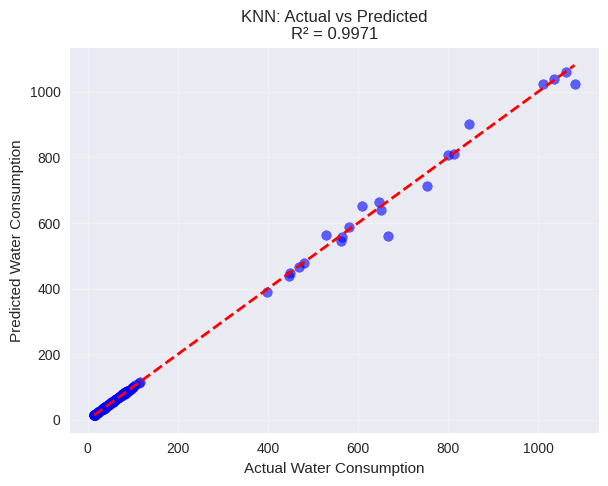

In [ ]:
# KNN Model Training
print("=" * 70)
print("K-NEAREST NEIGHBORS (KNN) MODEL TRAINING")
print("=" + "=" * 70)

### 1. Define and train KNN model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit # Import TimeSeriesSplit

# Create KNN pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Define parameter grid for KNN
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 20, 25],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski'],
    'knn__p': [1, 2]  # Power parameter for Minkowski metric
}

### 2. Instantiate GridSearchCV
knn_grid = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

### 3. Fit GridSearchCV to the training data
print("Training KNN model with GridSearchCV...")
knn_grid.fit(X_train, y_train)

### 4. Print the best parameters
print(f"\nBest KNN parameters: {knn_grid.best_params_}")
print(f"Best KNN cross-validation score: {-knn_grid.best_score_:.4f} (Negative MSE)")

### 5. Store the best estimator
best_knn = knn_grid.best_estimator_

### 6. Make predictions on the test set using the tuned model
y_pred_knn = best_knn.predict(X_test)

### 7. Evaluate the tuned model's performance
knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
knn_mae = mean_absolute_error(y_test, y_pred_knn)
knn_r2 = r2_score(y_test, y_pred_knn)
knn_mape = np.mean(np.abs((y_test - y_pred_knn) / y_test)) * 100

### 8. Print the evaluation metrics for the tuned KNN model
print("\nKNN Model Performance Metrics:")
print("-" * 40)
print(f"RMSE: {knn_rmse:.2f}")
print(f"MAE: {knn_mae:.2f}")
print(f"R² Score: {knn_r2:.4f}")
print(f"MAPE: {knn_mape:.2f}%")

### 9. Create a DataFrame to compare actual and predicted values
knn_comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_knn,
    'Absolute_Error': np.abs(y_test.values - y_pred_knn),
    'Percentage_Error': (np.abs(y_test.values - y_pred_knn) / y_test.values) * 100
})

# Sort by original values for better visualization
knn_comparison_df_sorted = knn_comparison_df.sort_values('Actual').reset_index(drop=True)

print(f"\nKNN Predictions Summary:")
print("-" * 30)
print(f"Mean Absolute Error: {knn_comparison_df['Absolute_Error'].mean():.2f}")
print(f"Max Absolute Error: {knn_comparison_df['Absolute_Error'].max():.2f}")
print(f"Mean Percentage Error: {knn_comparison_df['Percentage_Error'].mean():.2f}%")

### 10. Visualize the actual vs. predicted values
plt.figure(figsize=(15, 5))

# Plot 1: Scatter plot of actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_knn, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Consumption')
plt.ylabel('Predicted Water Consumption')
plt.title(f'KNN: Actual vs Predicted\nR² = {knn_r2:.4f}')
plt.grid(True, alpha=0.3)

# # Plot 2: Sorted values comparison
# plt.subplot(1, 2, 2)
# plt.plot(knn_comparison_df_sorted['Actual'], label='Actual', marker='o', markersize=3)
# plt.plot(knn_comparison_df_sorted['Predicted'], label='Predicted', marker='s', markersize=3)
# plt.xlabel('Sorted Test Samples')
# plt.ylabel('Water Consumption')
# plt.title('KNN: Sorted Actual vs Predicted Values')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# Additional KNN-specific analysis
print("\nKNN Model Insights:")
print("-" * 30)
print(f"Optimal number of neighbors: {knn_grid.best_params_['knn__n_neighbors']}")
print(f"Optimal weight function: {knn_grid.best_params_['knn__weights']}")
print(f"Optimal distance metric: {knn_grid.best_params_['knn__metric']}")

# Cross-validation results analysis
knn_cv_results = pd.DataFrame(knn_grid.cv_results_)
print(f"\nTop 5 KNN parameter combinations by CV score:")
top_knn_params = knn_cv_results.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_knn_params.iterrows():
    print(f"Score: {-row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")


RIDGE REGRESSION MODEL TRAINING
Training Ridge model with GridSearchCV...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits

Best Ridge parameters: {'ridge__alpha': 0.001, 'ridge__max_iter': 5000, 'ridge__solver': 'sag'}
Best Ridge cross-validation score: 302.8457 (Negative MSE)

Ridge Model Performance Metrics:
----------------------------------------
RMSE: 11.86
MAE: 7.38
R² Score: 0.9976
MAPE: 10.51%

Ridge Predictions Summary:
------------------------------
Mean Absolute Error: 7.38
Max Absolute Error: 56.04
Mean Percentage Error: 10.51%
Error: Unable to align feature names and coefficients.

Ridge Model Insights:
------------------------------
Optimal alpha (regularization strength): 0.001
Optimal solver: sag
Number of iterations: 5000

Top 5 Ridge parameter combinations by CV score:
Score: 302.8457 ± 154.9455
Score: 302.8457 ± 154.9455
Score: 303.3653 ± 153.6614
Score: 303.3653 ± 153.6614
Score: 306.6598 ± 154.1244


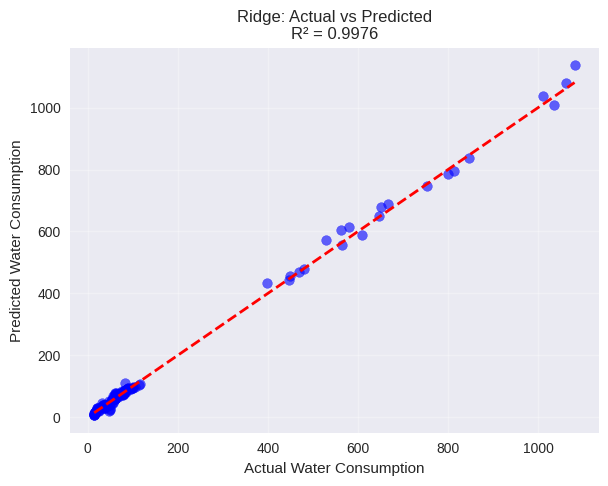

In [ ]:
# Ridge Model Training
print("\n" + "=" * 70)
print("RIDGE REGRESSION MODEL TRAINING")
print("=" + "=" * 70)

### 1. Define and train Ridge model
from sklearn.linear_model import Ridge

# Create Ridge pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=42))
])

# Define parameter grid for Ridge
ridge_param_grid = {
    'ridge__alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'],
    'ridge__max_iter': [1000, 5000, 10000]
}

### 2. Instantiate GridSearchCV
ridge_grid = GridSearchCV(
    ridge_pipeline,
    ridge_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

### 3. Fit GridSearchCV to the training data
print("Training Ridge model with GridSearchCV...")
ridge_grid.fit(X_train, y_train)

### 4. Print the best parameters
print(f"\nBest Ridge parameters: {ridge_grid.best_params_}")
print(f"Best Ridge cross-validation score: {-ridge_grid.best_score_:.4f} (Negative MSE)")

### 5. Store the best estimator
best_ridge = ridge_grid.best_estimator_

### 6. Make predictions on the test set using the tuned model
y_pred_ridge = best_ridge.predict(X_test)

### 7. Evaluate the tuned model's performance
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_mape = np.mean(np.abs((y_test - y_pred_ridge) / y_test)) * 100

### 8. Print the evaluation metrics for the tuned Ridge model
print("\nRidge Model Performance Metrics:")
print("-" * 40)
print(f"RMSE: {ridge_rmse:.2f}")
print(f"MAE: {ridge_mae:.2f}")
print(f"R² Score: {ridge_r2:.4f}")
print(f"MAPE: {ridge_mape:.2f}%")

### 9. Create a DataFrame to compare actual and predicted values
ridge_comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_ridge,
    'Absolute_Error': np.abs(y_test.values - y_pred_ridge),
    'Percentage_Error': (np.abs(y_test.values - y_pred_ridge) / y_test.values) * 100
})

# Sort by original values for better visualization
ridge_comparison_df_sorted = ridge_comparison_df.sort_values('Actual').reset_index(drop=True)

print(f"\nRidge Predictions Summary:")
print("-" * 30)
print(f"Mean Absolute Error: {ridge_comparison_df['Absolute_Error'].mean():.2f}")
print(f"Max Absolute Error: {ridge_comparison_df['Absolute_Error'].max():.2f}")
print(f"Mean Percentage Error: {ridge_comparison_df['Percentage_Error'].mean():.2f}%")

### 10. Visualize the actual vs. predicted values
plt.figure(figsize=(15, 5))

# Plot 1: Scatter plot of actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Consumption')
plt.ylabel('Predicted Water Consumption')
plt.title(f'Ridge: Actual vs Predicted\nR² = {ridge_r2:.4f}')
plt.grid(True, alpha=0.3)

# # Plot 2: Sorted values comparison
# plt.subplot(1, 2, 2)
# plt.plot(ridge_comparison_df_sorted['Actual'], label='Actual', marker='o', markersize=3)
# plt.plot(ridge_comparison_df_sorted['Predicted'], label='Predicted', marker='s', markersize=3)
# plt.xlabel('Sorted Test Samples')
# plt.ylabel('Water Consumption')
# plt.title('Ridge: Sorted Actual vs Predicted Values')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# Ridge coefficients analysis
ridge_model = best_ridge.named_steps['ridge']

# Get feature names after one-hot encoding, excluding 'Country code'
feature_names_out = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Ensure the number of feature names matches the number of coefficients
if len(feature_names_out) != len(ridge_model.coef_):
    print("Warning: Number of feature names does not match the number of coefficients.")
    # Attempt to align by excluding 'Country code' from the final feature list if it's still there
    if 'Country code' in feature_names_out:
        feature_names_out.remove('Country code')

# Re-check the length after potential removal
if len(feature_names_out) != len(ridge_model.coef_):
    print("Error: Unable to align feature names and coefficients.")
else:
    ridge_coefficients = pd.DataFrame({
        'Feature': feature_names_out,
        'Coefficient': ridge_model.coef_,
        'Absolute_Coefficient': np.abs(ridge_model.coef_)
    }).sort_values('Absolute_Coefficient', ascending=False)

    print("\nTop 10 Most Important Features (Ridge Coefficients):")
    print("-" * 50)
    for idx, row in ridge_coefficients.head(10).iterrows():
        print(f"{row['Feature']:35} : {row['Coefficient']:10.6f}")


# Additional Ridge-specific analysis
print(f"\nRidge Model Insights:")
print("-" * 30)
print(f"Optimal alpha (regularization strength): {ridge_grid.best_params_['ridge__alpha']}")
print(f"Optimal solver: {ridge_grid.best_params_['ridge__solver']}")
print(f"Number of iterations: {ridge_grid.best_params_['ridge__max_iter']}")

# Cross-validation results analysis
ridge_cv_results = pd.DataFrame(ridge_grid.cv_results_)
print(f"\nTop 5 Ridge parameter combinations by CV score:")
top_ridge_params = ridge_cv_results.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_ridge_params.iterrows():
    print(f"Score: {-row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")

LASSO REGRESSION MODEL TRAINING
Training LASSO model with GridSearchCV...
Fitting 5 folds for each of 168 candidates, totalling 840 fits

Best LASSO parameters: {'lasso__alpha': 0.01, 'lasso__max_iter': 5000, 'lasso__selection': 'cyclic', 'lasso__tol': 1e-05}
Best LASSO cross-validation score: 307.3727 (Negative MSE)

LASSO Model Performance Metrics:
----------------------------------------
RMSE: 11.83
MAE: 7.31
R² Score: 0.9976
MAPE: 10.11%

LASSO Predictions Summary:
------------------------------
Mean Absolute Error: 7.31
Max Absolute Error: 52.03
Mean Percentage Error: 10.11%


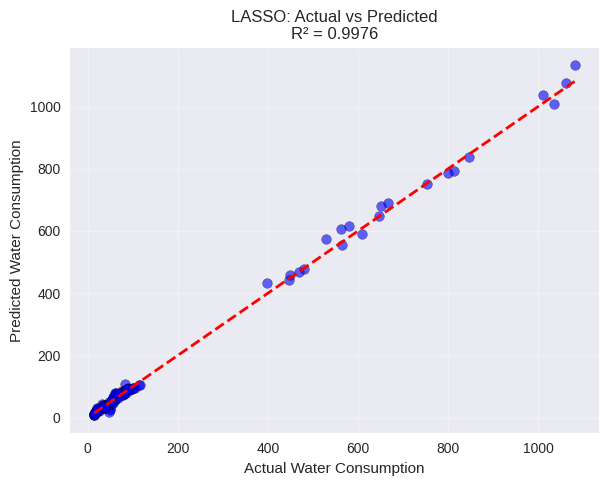

In [ ]:
# LASSO Model Training
print("=" * 70)
print("LASSO REGRESSION MODEL TRAINING")
print("=" + "=" * 70)

### 1. Define and train LASSO model
from sklearn.linear_model import Lasso

# Create LASSO pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

# Define parameter grid for LASSO
lasso_param_grid = {
    'lasso__alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
    'lasso__max_iter': [1000, 5000, 10000],
    'lasso__selection': ['cyclic', 'random'],
    'lasso__tol': [1e-4, 1e-5]
}

### 2. Instantiate GridSearchCV
lasso_grid = GridSearchCV(
    lasso_pipeline,
    lasso_param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

### 3. Fit GridSearchCV to the training data
print("Training LASSO model with GridSearchCV...")
lasso_grid.fit(X_train, y_train)

### 4. Print the best parameters
print(f"\nBest LASSO parameters: {lasso_grid.best_params_}")
print(f"Best LASSO cross-validation score: {-lasso_grid.best_score_:.4f} (Negative MSE)")

### 5. Store the best estimator
best_lasso = lasso_grid.best_estimator_

### 6. Make predictions on the test set using the tuned model
y_pred_lasso = best_lasso.predict(X_test)

### 7. Evaluate the tuned model's performance
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_mape = np.mean(np.abs((y_test - y_pred_lasso) / y_test)) * 100

### 8. Print the evaluation metrics for the tuned LASSO model
print("\nLASSO Model Performance Metrics:")
print("-" * 40)
print(f"RMSE: {lasso_rmse:.2f}")
print(f"MAE: {lasso_mae:.2f}")
print(f"R² Score: {lasso_r2:.4f}")
print(f"MAPE: {lasso_mape:.2f}%")

### 9. Create a DataFrame to compare actual and predicted values
lasso_comparison_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_lasso,
    'Absolute_Error': np.abs(y_test.values - y_pred_lasso),
    'Percentage_Error': (np.abs(y_test.values - y_pred_lasso) / y_test.values) * 100
})

# Sort by original values for better visualization
lasso_comparison_df_sorted = lasso_comparison_df.sort_values('Actual').reset_index(drop=True)

print(f"\nLASSO Predictions Summary:")
print("-" * 30)
print(f"Mean Absolute Error: {lasso_comparison_df['Absolute_Error'].mean():.2f}")
print(f"Max Absolute Error: {lasso_comparison_df['Absolute_Error'].max():.2f}")
print(f"Mean Percentage Error: {lasso_comparison_df['Percentage_Error'].mean():.2f}%")

### 10. Visualize the actual vs. predicted values
plt.figure(figsize=(15, 5))

# Plot 1: Scatter plot of actual vs predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lasso, alpha=0.6,edgecolor='black', color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Water Consumption')
plt.ylabel('Predicted Water Consumption')
plt.title(f'LASSO: Actual vs Predicted\nR² = {lasso_r2:.4f}')
plt.grid(True, alpha=0.3)

# # Plot 2: Sorted values comparison
# plt.subplot(1, 2, 2)
# plt.plot(lasso_comparison_df_sorted['Actual'], label='Actual', marker='o', markersize=3)
# plt.plot(lasso_comparison_df_sorted['Predicted'], label='Predicted', marker='s', markersize=3)
# plt.xlabel('Sorted Test Samples')
# plt.ylabel('Water Consumption')
# plt.title('LASSO: Sorted Actual vs Predicted Values')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

In [ ]:
# LASSO Feature Analysis and Coefficients
print("\n" + "=" * 70)
print("LASSO FEATURE ANALYSIS AND COEFFICIENTS")
print("=" + "=" * 70)

### Extract LASSO coefficients for analysis
lasso_model = best_lasso.named_steps['lasso']

# Get feature names after preprocessing
# Access the fitted preprocessor
fitted_preprocessor = preprocessor.fit(X, y)

# Get the transformed column names directly from the fitted preprocessor
# This will include all columns from the output of the ColumnTransformer
all_processed_features_out = fitted_preprocessor.get_feature_names_out()

# Ensure the number of feature names matches the number of coefficients from the Lasso model
if len(all_processed_features_out) != len(lasso_model.coef_):
    print(f"Error: Mismatch between number of feature names ({len(all_processed_features_out)}) and coefficients ({len(lasso_model.coef_)}).")
    # Attempt to diagnose further if needed
else:
    # Create comprehensive coefficient analysis
    lasso_coefficients = pd.DataFrame({
        'Feature': all_processed_features_out,
        'Coefficient': lasso_model.coef_,
        'Absolute_Coefficient': np.abs(lasso_model.coef_),
        'Is_Selected': lasso_model.coef_ != 0
    }).sort_values('Absolute_Coefficient', ascending=False)

    # Feature selection summary
    n_total = len(lasso_coefficients)
    n_selected = lasso_coefficients['Is_Selected'].sum()
    n_excluded = n_total - n_selected

    print(f"Feature Selection Summary:")
    print("-" * 30)
    print(f"Total Features: {n_total}")
    print(f"Selected Features (non-zero): {n_selected} ({n_selected/n_total*100:.1f}%)")
    print(f"Excluded Features (zero): {n_excluded} ({n_excluded/n_total*100:.1f}%)")

    # Display top coefficients
    print(f"\nTop 10 Most Important Features (LASSO Coefficients):")
    print("-" * 50)
    for idx, row in lasso_coefficients.head(10).iterrows():
        status = "SELECTED" if row['Is_Selected'] else "EXCLUDED"
        print(f"{row['Feature']:35} : {row['Coefficient']:10.6f} ({status})")

    # Display excluded features
    excluded_features = lasso_coefficients[~lasso_coefficients['Is_Selected']]
    if len(excluded_features) > 0:
        print(f"\nExcluded Features (Zero Coefficients):")
        print("-" * 40)
        for feature in excluded_features['Feature']:
            print(f"  {feature}")

    # Additional LASSO-specific analysis
    print(f"\nLASSO Model Insights:")
    print("-" * 30)
    print(f"Optimal alpha (regularization strength): {lasso_grid.best_params_['lasso__alpha']}")
    print(f"Optimal selection method: {lasso_grid.best_params_['lasso__selection']}")
    print(f"Number of iterations: {lasso_grid.best_params_['lasso__max_iter']}")

    # Cross-validation results analysis
    lasso_cv_results = pd.DataFrame(lasso_grid.cv_results_)
    print(f"\nTop 5 LASSO parameter combinations by CV score:")
    top_lasso_params = lasso_cv_results.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
    for idx, row in top_lasso_params.iterrows():
        print(f"Score: {-row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")


LASSO FEATURE ANALYSIS AND COEFFICIENTS
Feature Selection Summary:
------------------------------
Total Features: 36
Selected Features (non-zero): 34 (94.4%)
Excluded Features (zero): 2 (5.6%)

Top 10 Most Important Features (LASSO Coefficients):
--------------------------------------------------
num__Population                     : 265.222946 (SELECTED)
num__Household Water Use (%)        : 146.792135 (SELECTED)
cat__Country_England                : -130.056290 (SELECTED)
num__Per Capita Water Use (Liters per Day) :  87.078355 (SELECTED)
cat__Country_China                  : -78.475282 (SELECTED)
cat__Country_India                  : -74.671636 (SELECTED)
cat__Country_Russia                 : -58.059518 (SELECTED)
cat__Country_Australia              : -48.751585 (SELECTED)
cat__Country_Iraq                   :  48.709655 (SELECTED)
cat__Country_Iran                   :  45.911010 (SELECTED)

Excluded Features (Zero Coefficients):
----------------------------------------
  cat__Count

In [ ]:
# LASSO Model Interpretation
print("\n" + "=" * 70)
print("LASSO MODEL INTERPRETATION")
print("=" + "=" * 70)

# Business insights from LASSO model
print("\nBUSINESS INSIGHTS FROM LASSO MODEL:")
print("-" * 50)

# Define positive and negative drivers based on coefficients
positive_drivers = lasso_coefficients[lasso_coefficients['Coefficient'] > 0].sort_values('Coefficient', ascending=False)
negative_drivers = lasso_coefficients[lasso_coefficients['Coefficient'] < 0].sort_values('Coefficient', ascending=True)


# Key drivers analysis
if len(positive_drivers) > 0:
    top_positive = positive_drivers.iloc[0]
    print(f"STRONGEST POSITIVE DRIVER:")
    print(f"   • Feature: {top_positive['Feature']}")
    print(f"   • Impact: Each unit increases consumption by {top_positive['Coefficient']:.4f} billion cubic meters")
    print(f"   • Interpretation: This is the most significant factor increasing water demand")

if len(negative_drivers) > 0:
    top_negative = negative_drivers.iloc[0]
    print(f"\nSTRONGEST NEGATIVE DRIVER:")
    print(f"   • Feature: {top_negative['Feature']}")
    print(f"   • Impact: Each unit decreases consumption by {abs(top_negative['Coefficient']):.4f} billion cubic meters")
    print(f"   • Interpretation: This is the most significant factor reducing water demand")

# Model efficiency
print(f"\nMODEL EFFICIENCY:")
print(f"   • Features reduced by: {n_excluded}/{n_total} ({n_excluded/n_total*100:.1f}%)")
print(f"   • Model complexity: Reduced from {n_total} to {n_selected} features")
print(f"   • Performance: R² = {lasso_r2:.4f} with simplified model")

# Practical recommendations
print(f"\nPRACTICAL RECOMMENDATIONS:")
print(f"   1. Focus monitoring on the {n_selected} selected features")
print(f"   2. Prioritize interventions based on coefficient magnitudes")
print(f"   3. Consider removing {n_excluded} excluded features from data collection")
print(f"   4. Use this sparse model for interpretable forecasting")

# Risk assessment
print(f"\nRISK ASSESSMENT:")
print(f"   • Average prediction error: ±{lasso_mae:.2f} billion cubic meters")
print(f"   • Maximum observed error: {lasso_comparison_df['Absolute_Error'].max():.2f} billion cubic meters")
print(f"   • Relative accuracy: {100 - lasso_mape:.1f}% on average")


LASSO MODEL INTERPRETATION

BUSINESS INSIGHTS FROM LASSO MODEL:
--------------------------------------------------
STRONGEST POSITIVE DRIVER:
   • Feature: num__Population
   • Impact: Each unit increases consumption by 265.2229 billion cubic meters
   • Interpretation: This is the most significant factor increasing water demand

STRONGEST NEGATIVE DRIVER:
   • Feature: cat__Country_England
   • Impact: Each unit decreases consumption by 130.0563 billion cubic meters
   • Interpretation: This is the most significant factor reducing water demand

MODEL EFFICIENCY:
   • Features reduced by: 2/36 (5.6%)
   • Model complexity: Reduced from 36 to 34 features
   • Performance: R² = 0.9976 with simplified model

PRACTICAL RECOMMENDATIONS:
   1. Focus monitoring on the 34 selected features
   2. Prioritize interventions based on coefficient magnitudes
   3. Consider removing 2 excluded features from data collection
   4. Use this sparse model for interpretable forecasting

RISK ASSESSMENT:
  

In [ ]:
# Create a dictionary to store the metrics for each model
model_comparison = {
    'Model': ['KNN', 'Ridge', 'LASSO'],
    'RMSE': [knn_rmse, ridge_rmse, lasso_rmse],
    'MAE': [knn_mae, ridge_mae, lasso_mae],
    'R2 Score': [knn_r2, ridge_r2, lasso_r2]

}

# Create a pandas DataFrame from the dictionary
model_comparison_df = pd.DataFrame(model_comparison)

# Set 'Model' as the index for better readability
model_comparison_df.set_index('Model', inplace=True)

# Display the comparison table
print("\n=== Model Comparison Table ===")
print("=" * 30)
display(model_comparison_df)

print("\nModel comparison complete.")


=== Model Comparison Table ===


,RMSE,MAE,R2 Score
Model,,,
KNN,13.054792,3.504391,0.997083
Ridge,11.855971,7.376344,0.997594
LASSO,11.833242,7.307412,0.997604



Model comparison complete.


In [ ]:
# List of features the user is interested in
user_features = [
    'Population',
    'Per Capita Water Use (Liters per Day)',
    'Agricultural Water Use (%)',
    'Household Water Use (%)',
    'Rainfall Impact (Annual Precipitation in mm)',
    'Groundwater Depletion Rate (%)',
    'Water Scarcity Level',
    'Number of dams',
    'Reservoir_Capacity_TMC',
    'Number_of_Industries'
]

# Get the lasso coefficients DataFrame (assuming it's already created in a previous cell)
# Make sure the 'Feature' column in lasso_coefficients matches the format of user_features

# Filter the lasso_coefficients DataFrame for the user's listed features
# Need to handle the naming convention from the preprocessor (e.g., 'num__Population', 'cat__Water Scarcity Level_Low')
filtered_coefficients = lasso_coefficients[
    lasso_coefficients['Feature'].apply(lambda x: any(feat in x for feat in user_features))
].copy() # Use .copy() to avoid SettingWithCopyWarning

print("LASSO Coefficients for Specified Features:")
print("-" * 50)

# Display the filtered coefficients
# Including the 'Is_Selected' column to show if the coefficient is zero
display(filtered_coefficients[['Feature', 'Coefficient', 'Is_Selected']])

print("\n'Is_Selected' column indicates if the feature's coefficient is non-zero (True) or zero (False), meaning it was shrunk by LASSO.")

LASSO Coefficients for Specified Features:
--------------------------------------------------


,Feature,Coefficient,Is_Selected
1,num__Population,265.222946,True
5,num__Household Water Use (%),146.792135,True
2,num__Per Capita Water Use (Liters per Day),87.078355,True
3,num__Agricultural Water Use (%),-32.174228,True
6,num__Rainfall Impact (Annual Precipitation in mm),28.877310,True
10,num__Number_of_Industries,-28.320201,True
8,num__Number of dams,18.490924,True
9,num__Reservoir_Capacity_TMC,9.402121,True
7,num__Groundwater Depletion Rate (%),6.831735,True
34,cat__Water Scarcity Level_Moderate,-2.116701,True



'Is_Selected' column indicates if the feature's coefficient is non-zero (True) or zero (False), meaning it was shrunk by LASSO.
